In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
device="cpu"
import warnings
warnings.filterwarnings('always')
pd.options.mode.chained_assignment = None
#cpu = not torch.cuda.is_available()
#device = torch.device("cpu" if cpu else "cuda")

In [2]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn import metrics
%matplotlib inline

In [3]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained("bert-base-multilingual-cased")

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [82]:
import pickle

In [34]:
df=pd.read_csv('search_queries_candidate_dataset__jan_2024.csv')

In [35]:
df.shape

(599, 8)

In [36]:
df.head(5)

,date,search_query,market,geo_country,device_type,browser_name,intent,daily_query_count
0,2023-12-08,google translate,en-gb,GB,Desktop,Chrome,TRANSLATION,2
1,2023-12-08,rephrase,en-gb,GB,Desktop,Chrome,DICTIONARY,2
2,2023-12-31,amazon,en-gb,GB,Mobile,Chrome,NAVIGATION,2
3,2023-12-29,facebook,fr-fr,FR,Mobile,Ecosia ios,NAVIGATION,3
4,2023-12-23,tv programm,de-de,DE,Mobile,Safari,OTHER,3


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               599 non-null    object
 1   search_query       599 non-null    object
 2   market             541 non-null    object
 3   geo_country        535 non-null    object
 4   device_type        539 non-null    object
 5   browser_name       541 non-null    object
 6   intent             537 non-null    object
 7   daily_query_count  599 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 37.6+ KB


# Data preprocessing

## Feature Engineering and Selection

There are 3 types of data in this dataset:  
1. Categorical data
2. Numeric data
3. Text

### Categorical data  
Each categorical metric will have to be converted into multiple dummy variables or perform one hot encoding. Therefore, to reduce the number of dummy variables we will try to reduce the number of categories whenever possible/appropriate or entirely ignore a variable.

### Numerical data
Numerical data will be scaled to the range (0,1)

### Text data
The textual data will be converted to corresponding vector embeddings

### Missing values
Check if data has missing values. Missing values need to be handled properly.  

In [38]:
nan_percentage=(df.isnull().sum() / len(df) * 100).round(2)
nan_percentage

date                  0.00
search_query          0.00
market                9.68
geo_country          10.68
device_type          10.02
browser_name          9.68
intent               10.35
daily_query_count     0.00
dtype: float64

### Start by Analysing the target metric

### Metric: intent (target metric)
The task is intent classification, therefore our target metric is 'intent'.  
For this metric 10.35% of the values are missing. These data samples cannot be used for training and testing of the model and therefore will be directly removed.  
Observe the distribution of the metric

In [39]:
target_metric='intent'
df=df.loc[~df[target_metric].isnull()]
print(f'Percentage of missing values in the target metric intent is {(df[target_metric].isnull().sum()/len(df)*100).round(2)}')

Percentage of missing values in the target metric intent is 0.0


### Distribution of the target metric

In [40]:
def intent_distribution(df,target):
    sns.set()
    plt.figure(figsize = (12, 8))
    chart = sns.countplot(x = target, data = df, palette='pastel')
    chart.set_xticklabels(chart.get_xticklabels(), rotation = 30, horizontalalignment='right', fontweight='light', fontsize='medium')
    chart.set_title('Intent Distribution', fontsize = 18)
    chart.set_xlabel('Intents', fontsize = 14)
    chart.set_ylabel('Counts', fontsize = 14)
    plt.show()

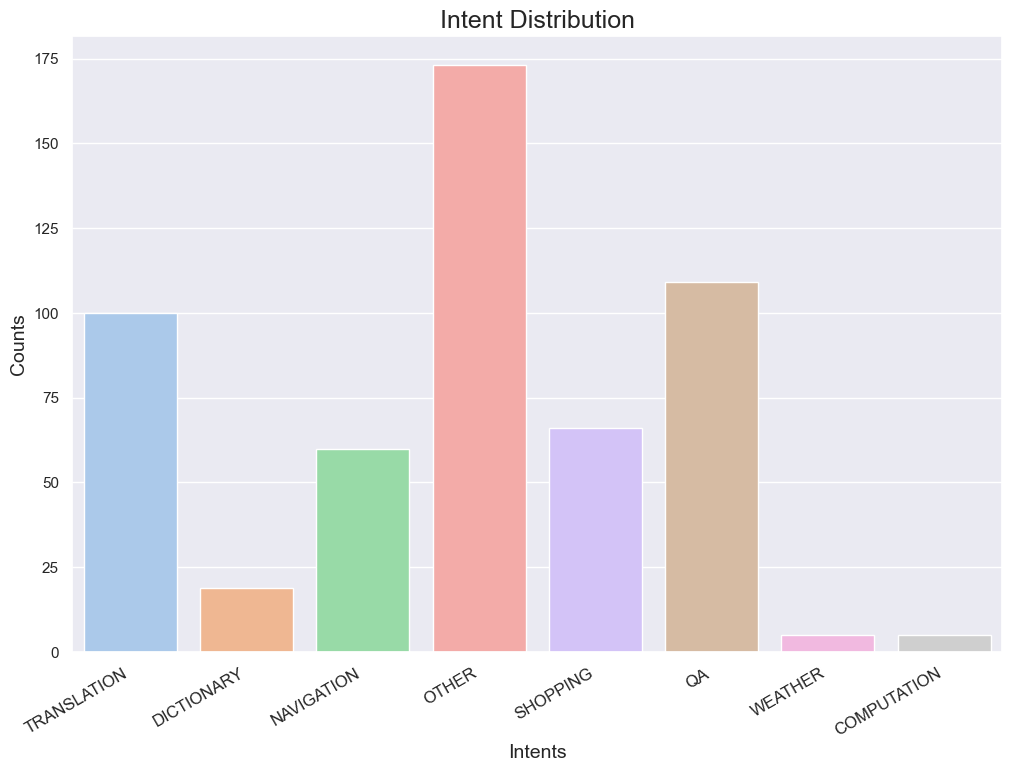

In [41]:
intent_distribution(df,'intent')

In [42]:
df['intent'].value_counts(normalize=True)*100

intent
OTHER          32.216015
QA             20.297952
TRANSLATION    18.621974
SHOPPING       12.290503
NAVIGATION     11.173184
DICTIONARY      3.538175
WEATHER         0.931099
COMPUTATION     0.931099
Name: proportion, dtype: float64

In [43]:
nan_percentage=(df.isnull().sum() / len(df) * 100).round(2)
nan_percentage

date                 0.00
search_query         0.00
market               3.72
geo_country          4.84
device_type          4.10
browser_name         3.17
intent               0.00
daily_query_count    0.00
dtype: float64

### Encode intents into intent_id

In [44]:
df['intent_id']=df['intent'].factorize()[0]

In [45]:
intent_id_df = df[['intent', 'intent_id']].drop_duplicates().sort_values('intent_id')
#intent_to_id = dict(intent_id_df.values)
id_to_intent = dict(intent_id_df[['intent_id', 'intent']].values)

C:\Users\rashm\anaconda3\envs\mwml\lib\site-packages\pandas\core\dtypes\cast.py:1429: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [46]:
id_to_intent

{0: 'TRANSLATION',
 1: 'DICTIONARY',
 2: 'NAVIGATION',
 3: 'OTHER',
 4: 'SHOPPING',
 5: 'QA',
 6: 'WEATHER',
 7: 'COMPUTATION'}

In [47]:
df.drop('intent',axis=1,inplace=True)

### Metric: date
This metric will be ignored for simplicity

In [48]:
df.drop('date',axis=1,inplace=True)

### Categorical metrics
Each categorical metric will have to be converted into multiple dummy variables or perform one hot encoding. Therefore, to reduce the number of dummy variables we will try to reduce the number of categories whenever possible/appropriate or entirely ignore a variable.  
These metrics will be one hot encoded and missing values will be filled with 'other'

In [49]:
cat_metrics=['market','geo_country','device_type','browser_name']
for metric in cat_metrics:
    df[metric].fillna('other',inplace=True)

### Metric: geo_country
Countries 'US','AT','GH' are grouped as 'other' as they have very few corresponding data samples

In [50]:
df['geo_country'].value_counts()

geo_country
FR       204
DE       194
GB       100
other     26
CN         6
US         3
AT         3
GH         1
Name: count, dtype: int64

In [51]:
other=['US','AT','GH']
df['geo_country'] = df['geo_country'].apply(lambda x: 'other' if x in other else x)
df['geo_country'].value_counts(normalize=True)*100

geo_country
FR       37.988827
DE       36.126629
GB       18.621974
other     6.145251
CN        1.117318
Name: proportion, dtype: float64

### Metric: device_type
device_type 'Tablet' is grouped as 'other' as there are very few corresponding data samples

In [52]:
df['device_type'].value_counts()

device_type
Desktop    264
Mobile     248
other       22
Tablet       3
Name: count, dtype: int64

In [53]:
df['device_type'] = df['device_type'].apply(lambda x: 'other' if x == 'Tablet' else x)

### Metric: browser_name
Browser name 'Brave' is grouped as 'other' as there are very few corresponding data samples

In [54]:
df['browser_name'].value_counts()

browser_name
Chrome        163
Chromium      147
Safari         56
Ecosia ios     53
Edge           51
Firefox        49
other          17
Brave           1
Name: count, dtype: int64

In [55]:
df['browser_name'] = df['browser_name'].apply(lambda x: 'other' if x == 'Brave' else x)

### Numeric metric: daily_query_count
This metric will be scaled to the range of (0,1)

In [56]:
def preprocess_num(values,scaler):    
    scaled_values=scaler.transform(values)
    return scaled_values

### Text Metric: search_query
This metric does not have any missing values. The queries are multi-lingual, including the following languages: English, German, French and Chinese. Bert base multilingual is used for computing the word embeddings

In [57]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained("bert-base-multilingual-cased")

def get_text_embeddings(text):
    # Tokenize and convert text to embeddings
    input_ids = tokenizer.encode(text, return_tensors="pt",truncation=True)
    with torch.no_grad():
        outputs = model(input_ids)

    # The embeddings are contained in the last layer of the model's output
    last_hidden_states = outputs.last_hidden_state

    # You can extract the embedding for each token in the input
    # For a simple example, you can average the embeddings across all tokens
    average_embedding = torch.mean(last_hidden_states, dim=1).squeeze().numpy()

    return average_embedding

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [58]:
def preprocess_text(queries):
    col_embed=[]
    for query in queries:
        col_embed.append(get_text_embeddings(query))
    #reduce the dimensionality of the embeddings
    #reduced_embed=dense(torch.tensor(col_embed))
    return np.array(col_embed)

### Stratify split dataset into train and test 

In [59]:
df.columns

Index(['search_query', 'market', 'geo_country', 'device_type', 'browser_name',
       'daily_query_count', 'intent_id'],
      dtype='object')

In [60]:
y=df['intent_id'] #labels
df.drop('intent_id',axis=1,inplace=True)
X=df
df_train, df_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.05,random_state=42)

In [61]:
df_train.columns

Index(['search_query', 'market', 'geo_country', 'device_type', 'browser_name',
       'daily_query_count'],
      dtype='object')

## Preprocess data 
### Categorical data

Fit one hot encoder on train data first and use it for test data

In [62]:
encoder = OneHotEncoder(handle_unknown = 'ignore')
encoder.fit(df_train[cat_metrics])
train_cat=encoder.transform(df_train[cat_metrics]).toarray()
test_cat=encoder.transform(df_test[cat_metrics]).toarray()

### Numeric data

Fit minmax scaler on train data first and use it for test data

In [63]:
scaler = MinMaxScaler()
values=df_train['daily_query_count'].values.reshape(-1,1)
scaler.fit(values)

train_num=preprocess_num(values,scaler)

values=df_test['daily_query_count'].values.reshape(-1,1)
test_num=preprocess_num(values,scaler)

### Text data

The queries are multi-lingual, including the following languages: English, German, French and Chinese. Bert base multilingual is used for computing the word embeddings

In [64]:
train_query=preprocess_text(df_train['search_query'])
X_train=np.concatenate((train_cat,train_num,train_query),axis=1)

test_query=preprocess_text(df_test['search_query'])
X_test=np.concatenate((test_cat,test_num,test_query),axis=1)

In [65]:
X_train.shape, X_test.shape

((510, 789), (27, 789))

In [84]:
def save_model(model,file_name):
    with open(file_name, 'wb') as file:  
        pickle.dump(model, file)

In [85]:
save_model(scaler,'scaler.pkl')
save_model(encoder,'encoder.pkl')

### XGB Classifier is chosen for the classification 

In [66]:
XGBclassifier = XGBClassifier()

clf_dict = {            
            "XGBClassifier": XGBclassifier,           
            }

In [67]:
def fit_classifier(label, clf, X_train, y_train):
    print('======================================================')
    print("Training Classifier : ", label)
    return clf.fit(X_train, y_train)

In [68]:
def test_classifier(label, clf, X_test, y_test):
    print('======================================================')
    print("Testing Classifier: ", label)
    
    y_pred = clf.predict(X_test)
    #classification_report = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision,recall,fscore,support=precision_recall_fscore_support(y_test,y_pred,average='macro')
    print('\nClassification Metrics:')
    print('Precision : {}'.format(precision))
    print( 'Recall    : {}'.format(recall))
    print('F-score   : {}'.format(fscore))
    print('Accuracy  : {}'.format(accuracy))
    print('======================================================')

In [69]:
def train_clf(clf_dict, X_train, y_train):
    
    print("Training the model:")
    
    for label, clf in clf_dict.items():
        print(np.unique(y_train))
        trained_classifier = fit_classifier(label, clf, X_train, y_train)
        print('======================================================')
    return trained_classifier

### Train classifier

In [70]:
trained_classifier=train_clf(clf_dict, X_train, y_train)

Training the model:
[0 1 2 3 4 5 6 7]
Training Classifier :  XGBClassifier


### Test classifier on hold out

In [71]:
test_classifier("XGBClassifier", trained_classifier, X_test, y_test)

Testing Classifier:  XGBClassifier

Classification Metrics:
Precision : 0.6666666666666666
Recall    : 0.55
F-score   : 0.5767195767195767
Accuracy  : 0.6296296296296297


In [79]:
def evaluate_model_performance(df_test):
    queries=df_test['search_query'].values
    for metric in ['market','geo_country','device_type','browser_name']:
        df_test[metric].fillna('other',inplace=True)
    input_cat=encoder.transform(df_test[cat_metrics]).toarray()
    values=df_test['daily_query_count'].values.reshape(-1,1)
    input_num=preprocess_num(values,scaler)
    input_query=preprocess_text(df_test['search_query'])
    data_input=np.concatenate((input_cat,input_num,input_query),axis=1) 
    y_pred=trained_classifier.predict(data_input)
    for i,pred in enumerate(y_pred):
        print(f'Query: {queries[i]}, Intent:{id_to_intent[pred]}')
    print(y_pred)

In [80]:
evaluate_model_performance(df_test.head(9))

Query: antonin artaud lycee marseille, Intent:QA
Query: handkreissäge, Intent:OTHER
Query: übersetzer, Intent:DICTIONARY
Query: chatgpt, Intent:OTHER
Query: nintendo switch, Intent:OTHER
Query: google traduction, Intent:TRANSLATION
Query: google übersetzer, Intent:TRANSLATION
Query: franceinfo, Intent:QA
Query: google traduction, Intent:TRANSLATION
[5 3 1 3 3 0 0 5 0]
